## Competition Rules
1. At most 10 features allowed as inputs to regressions.
2. At least 8500 samples in the signal need to be tested against the proposed regression.
3. The competition is split into two categories:
     * First category: data generated with default phase.
     * Second category: data generated with random phase via create_signal(phase=np.random.rand()*2*np.pi) - see code below.
4. Only use functions encountered here and in past exercises.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from icecream import ic

In [2]:
def create_signal(noise_sigma=0.25, phase=np.pi/4, num_cycles=10, max_lookback=1000, feature_jump=29, look_forward=500):

    X = np.linspace(0, num_cycles*np.pi, 1000*num_cycles) 
    N = np.random.normal(0, noise_sigma*np.abs((np.sin(X + phase))), len(X))
    Y = np.sin(X) + N

    # Create the "signal" dataframe, along with exponential-moving-average mean & std.
    # We add 10 so we only have to deal with strictly positive samples.
    sig_df = pd.DataFrame({'time':X, 'signal':Y+10})

    # Put together a big bunch of Ronny-Roshbakir style features.
    # Ronny samples the signals' log-gains at feature_jumps intervals, up to max_lookback steps back.
    # These features do a poor job of capturing the underlying dynamics of the problem.
    features = {'ronny':[], 'motti':[], 'batya':[]}
    for i in range(max_lookback):
        if i%feature_jump==0:
            curr_feature = 'sig_gain_' + str(i+1)
            features['ronny'].append(curr_feature)
            # The log-gain feature is invariant to the signal's magnitude, and therefore makes sense when trading.
            sig_df[curr_feature] = 100*(np.log(sig_df['signal']) - np.log(sig_df['signal'].shift(periods=(i+1))))

    # Motti's features are better: they extract the signal's exponentially decaying mean & standard deviation.
    window_lengths = [5, 10, 50, 100, 1000]
    for win_len in window_lengths:
        # Pandas' ewm() provides exponentially weighted functions (here we use mean & std()).
        # The win_len parameter (see below) controls the "center-of-mass" ("COM", see documentation) of the moving average.
        # Note that the moving average considers ALL previous data, but after ~3 COMs the contribution is negligible.
        # This also means that the first ~3 COMs of data will be less reliable then the subsequent signal.
        # HENCE... We restrict the outputs s.t. only windows with at least the maximal window length observations are avail.
        sig_df['ewm_mean_'+str(win_len)] = sig_df['signal'].ewm(win_len, min_periods=max(window_lengths)).mean()
        sig_df['ewm_std_'+str(win_len)] = sig_df['signal'].ewm(win_len, min_periods=max(window_lengths)).std()
        features['motti'].append('ewm_mean_'+str(win_len))
        features['motti'].append('ewm_std_'+str(win_len))

    # Feel free to place additional super-smart Batya-Bingo features here:
    # sig_df['bla_bla_666'] = something_really_smart
    # features['batya'].append('bla_bla_666')
    
    # The 20-day exponential moving averages and STDs are used (only) in the graphs below.
    sig_df['ewm_mean_20'] = sig_df['signal'].ewm(20).mean()
    sig_df['ewm_std_20'] = sig_df['signal'].ewm(20).std()
       
    # Extract a few "future features" (will be used for constructing the target).
    # We're interested in looking (no more than) look_forward steps into the future.
    # NOTICE: again, we restrict the outputs s.t. only windows with at least look_forward observations are avail.
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=look_forward)
    sig_df['future_mean'] = sig_df['signal'].rolling(window=indexer, min_periods=look_forward).mean()
    sig_df['future_std'] = sig_df['signal'].rolling(window=indexer, min_periods=look_forward).std()
    
    # Option 1: assume access to the "clean" signal when calculating the future_gain (in practice of course we wouldn't).
    sig_df['future_gain'] = 100*(np.log(sig_df['future_mean']) - np.log(10 + np.sin(X)))
    # Option 2: in a slightly more realistic scenario we would be doing something like this:
    # sig_df['future_gain'] = 100*(np.log(sig_df['future_mean']) - np.log(sig_df['ewm_mean']))

    # Our target divides the future gain by the future standard deviation + 1 (we don't like volatility!).
    sig_df['target'] = sig_df['future_gain'].divide(sig_df['future_std'] + 1)

    return(sig_df, features)

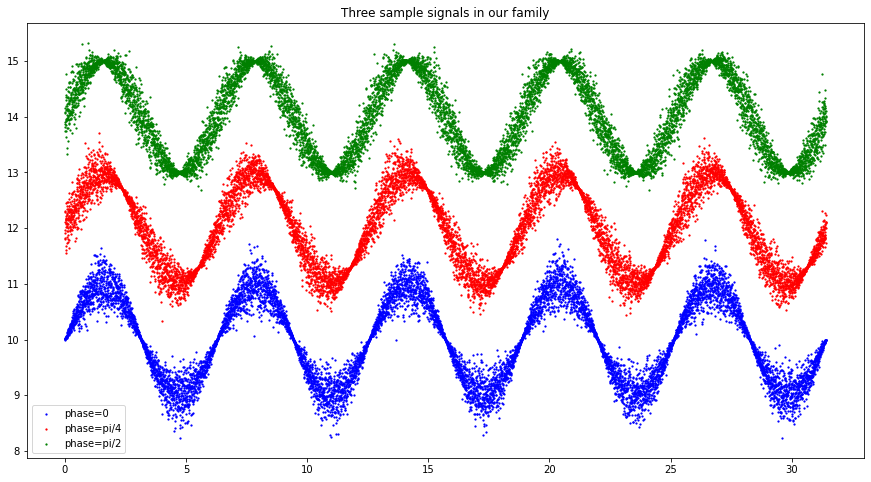

In [3]:
# Show off today's signal family.
plt.rcParams['figure.figsize'] = [15, 8]
sig1_df, _ = create_signal(phase=0)           # The "_" by convention means we do not plan to use a returned variable.
sig2_df, _ = create_signal(phase=np.pi/4)
sig3_df, _ = create_signal(phase=np.pi/2)
fig, axes = plt.subplots()
plt.scatter(sig1_df['time'], sig1_df['signal'], color='b', s=1.5, label='phase=0');
plt.scatter(sig2_df['time'], sig2_df['signal']+2, color='r', s=1.5, label='phase=pi/4');
plt.scatter(sig3_df['time'], sig3_df['signal']+4, color='g', s=1.5, label='phase=pi/2');
plt.title("Three sample signals in our family")
plt.legend();

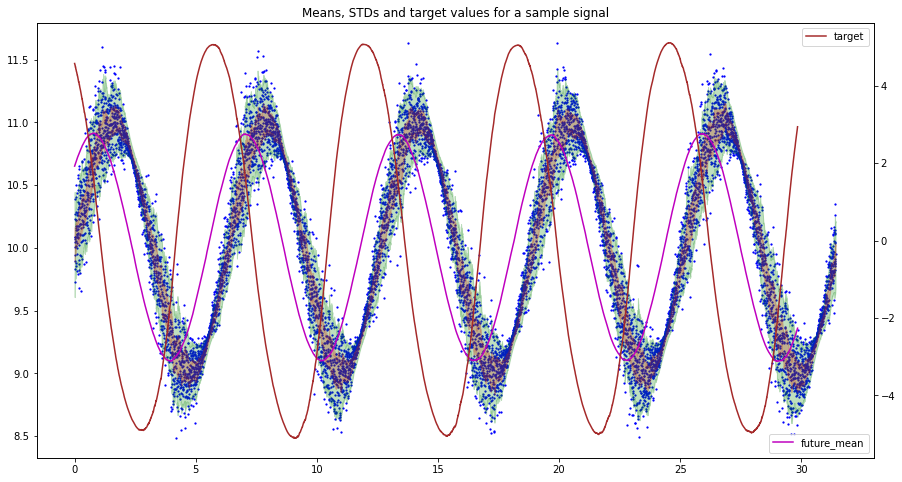

In [4]:
sig_df, features = create_signal()
fig, ax = plt.subplots()
plt.title("Means, STDs and target values for a sample signal")
plt.scatter(sig_df['time'], sig_df['signal'], color='b', s=1.5)
ax.fill_between(sig_df['time'], sig_df['ewm_mean_20']-0.5*sig_df['ewm_std_20'], sig_df['ewm_mean_20']+0.5*sig_df['ewm_std_20'], color='r', alpha=0.25)
ax.fill_between(sig_df['time'], sig_df['ewm_mean_20']-1.5*sig_df['ewm_std_20'], sig_df['ewm_mean_20']+1.5*sig_df['ewm_std_20'], color='g', alpha=0.25)
ax.plot(sig_df['time'], sig_df['future_mean'], color='m', label='future_mean')
ax.legend(loc="lower right")
ax2 = ax.twinx()
ax2.plot(sig_df['time'], sig_df['target'], color='brown', label='target')
ax2.legend();

In [5]:
# Prepare a dataset using only Ronny's features, clean by dropping all rows with missing data.
ronny_clean_df = sig_df[features['ronny'] + ['target']].dropna()
X_ronny_df = ronny_clean_df[features['ronny']]
y_ronny = ronny_clean_df['target']

motti_clean_df = sig_df[features['motti'] + ['target']].dropna()
X_motti_df = motti_clean_df[features['motti']]
y_motti = motti_clean_df['target']

In [6]:
# Train a linear regressor on the continuous target.
# NOTICE: when we predict we keep the resulting index to avoid confusion later!
ronny_reg = LinearRegression()
ronny_reg.fit(X_ronny_df, y_ronny)
ic(ronny_reg.n_features_in_)

# Use Motti's features to estimate the target directly.
motti_reg = LinearRegression()
motti_reg.fit(X_motti_df, y_motti)
ic(motti_reg.n_features_in_);

ic| ronny_reg.n_features_in_: 35
ic| motti_reg.n_features_in_: 10


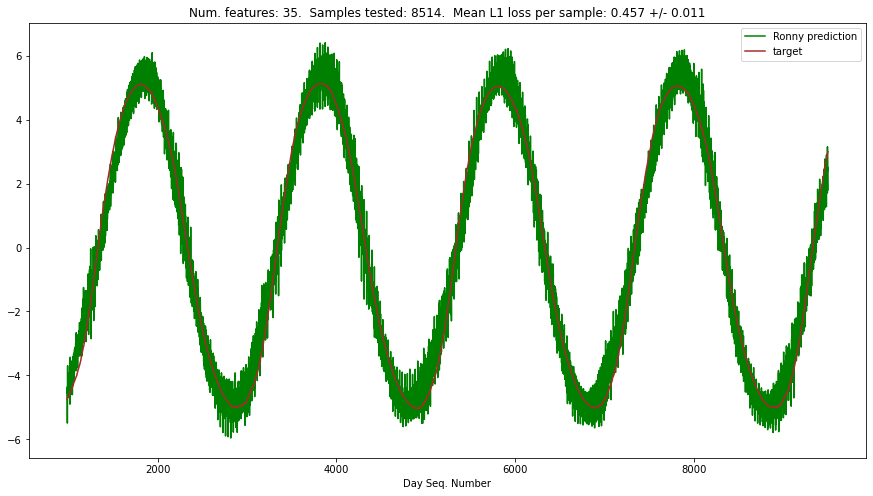

In [7]:
l1_loss=[]
for _ in range(100):
    
    # NOTICE: activate the first line (constant phase) for Category A of the competition.
    # NOTICE: activate the second line (random phase) for Category B of the competition.
    ronny_sig_df, features = create_signal()  # Category A
    # ronny_sig_df, features = create_signal(phase=np.random.rand()*2*np.pi)  # Category B

    # Extract the same set of features + target.
    ronny_clean_df = ronny_sig_df[features['ronny'] + ['target']].dropna()
    ronny_X_df = ronny_clean_df[features['ronny']]
    ronny_y = ronny_clean_df['target']

    # Notice we're using ronny_reg, the previously constructed regressor.
    ronny_pred = pd.Series(ronny_reg.predict(ronny_X_df), index=ronny_X_df.index)
    # Add the l1 loss *per sample*. This way we can compare regressors with different support sets.
    ronny_l1_loss = np.sum(np.abs(ronny_y - ronny_pred)) / len(ronny_y)
    l1_loss.append(ronny_l1_loss)

# Show the (last in loop) output.
fig, ax = plt.subplots()
ax.set(xlabel='Day Seq. Number', title='Num. features: ' + str(len(features['ronny'])) + \
       ".  Samples tested: " + str(len(ronny_y)) + ".  Mean L1 loss per sample: " + \
       str(np.round(np.mean(l1_loss), 3)) + " +/- " + str(np.round(np.std(l1_loss), 3)))
ax.plot(ronny_pred, label='Ronny prediction', color='green')
ax.plot(ronny_y, label='target', color='brown')
ax.legend();

Change the dataset's distribution by adding a random phase (see commented out line).<br>
Before running the simulation, guess what you think should happen...

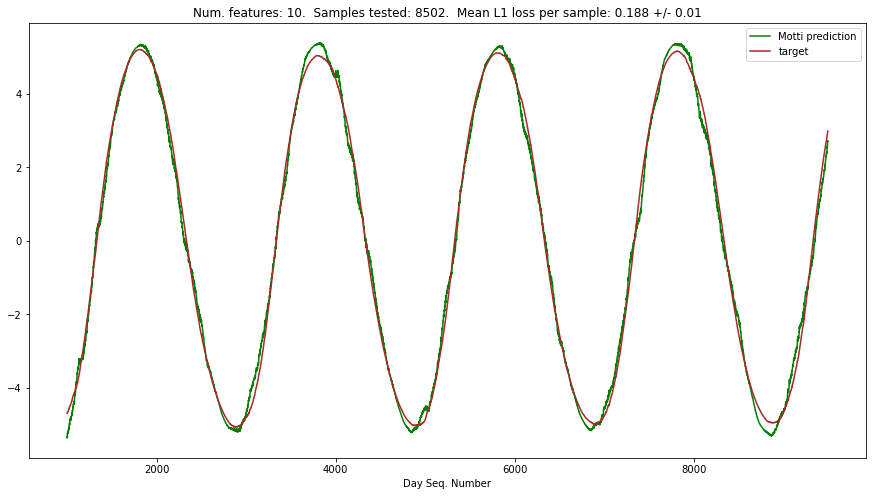

In [8]:
# Repeat the whole procedure using Motti's features, iterating with a different random phase.
l1_loss=[]
for _ in range(100):
    motti_sig_df, features = create_signal()
    # motti_sig_df, features = create_signal(phase=np.random.rand()*2*np.pi)

    # Extract the same set of features + target.
    motti_clean_df = motti_sig_df[features['motti'] + ['target']].dropna()
    motti_X_df = motti_clean_df[features['motti']]
    motti_y = motti_clean_df['target']

    # Notice we're using motti_reg, the previously constructed regressor.
    motti_pred = pd.Series(motti_reg.predict(motti_X_df), index=motti_X_df.index)
    motti_l1_loss = np.sum(np.abs(motti_y - motti_pred)) / len(motti_y)
    l1_loss.append(motti_l1_loss)

# Show the (last in loop) output.
fig, ax = plt.subplots()
ax.set(xlabel='Day Seq. Number', title='Num. features: ' + str(motti_reg.n_features_in_) + \
       ".  Samples tested: " + str(len(motti_y)) + ".  Mean L1 loss per sample: " + \
       str(np.round(np.mean(l1_loss), 3)) + " +/- " + str(np.round(np.std(l1_loss), 3)))
ax.plot(motti_pred, label='Motti prediction', color='green')
ax.plot(motti_y, label='target', color='brown')
ax.legend();